In [4]:
from math import radians, sin, cos
import math
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import numpy as np

In [5]:
"""рунге-кутта-4"""

def rk4(y, x, dx, f):
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

In [6]:
def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t

In [7]:
class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

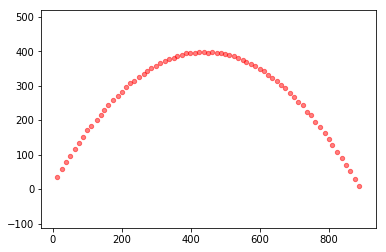

In [8]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

In [9]:
def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    kf = KalmanFilter(dim_x=4, dim_z=2, dim_u=1)

    kf.F = np.array([[1., dt, 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 1.]])  # dy  = dy0

    kf.H = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.]])
    
    kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

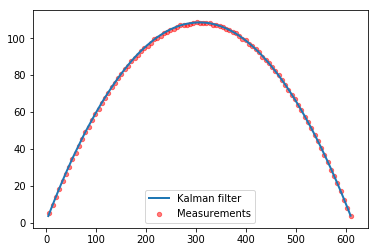

In [10]:
def track_ball_vacuum(dt):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 80.
    g = 9.8 # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T

        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])    
        kf.predict(u=-g)     
        p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2)
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    
track_ball_vacuum(dt=1./10)